In [5]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 18.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=da415721de51011212d8cc5a370821b3aa1c0d4f09718ad7747be7da038fb87d
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [1]:
# 한국거래소에서 상장법인목록을 엑셀로 다운

import pandas as pd
stock_code = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0] 
stock_code.head()

stock_code.sort_values(['상장일'], ascending=True)
stock_code = stock_code[['회사명', '종목코드']] 
stock_code = stock_code.rename(columns={'회사명': 'company', '종목코드': 'code'}) 
stock_code.code = stock_code.code.map('{:06d}'.format) 

company='우양' 
code = stock_code[stock_code.company==company].code.values[0].strip()
page_no = 1


# 종목 URL 만들기

url = f"https://finance.naver.com/item/sise_day.nhn?code={code}&page={page_no}"

# HTTP 요청

import requests
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}
response = requests.get(url, headers=headers)


# table 태그 찾기

from bs4 import BeautifulSoup as bs
html = bs(response.text, "lxml")
table = html.select("table")

# url의 page내의 값을 DataFrame으로 변환
table = pd.read_html(str(table))
#table[1]

# 결측치 제거
temp = table[0].dropna()
temp

,날짜,종가,전일비,시가,고가,저가,거래량
1,2021.06.21,5770.0,140.0,5870.0,5890.0,5750.0,91102.0
2,2021.06.18,5910.0,60.0,5960.0,5970.0,5900.0,94594.0
3,2021.06.17,5970.0,10.0,5980.0,5990.0,5900.0,85826.0
4,2021.06.16,5980.0,0.0,5960.0,6050.0,5920.0,104388.0
5,2021.06.15,5980.0,30.0,5950.0,5990.0,5890.0,74347.0
9,2021.06.14,5950.0,10.0,6010.0,6020.0,5920.0,73217.0
10,2021.06.11,5960.0,110.0,5930.0,5980.0,5860.0,86074.0
11,2021.06.10,5850.0,80.0,5910.0,6050.0,5650.0,156416.0
12,2021.06.09,5930.0,30.0,5920.0,6150.0,5880.0,178333.0
13,2021.06.08,5900.0,0.0,5930.0,5940.0,5800.0,84675.0


In [2]:
# 종목 번호를 이용해 page에 따라 데이터를 읽는 함수

def get_day_list(item_code, page_no):
    """
    일자별 시세를 페이지별로 수집
    """ 
    url = f"https://finance.naver.com/item/sise_day.nhn?code={item_code}&page={page_no}"
    
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}

    response = requests.get(url, headers=headers)
    html = bs(response.text, "lxml")
    table = html.select("table")
    table = pd.read_html(str(table))
    temp = table[0].dropna()
    return temp

In [3]:
import time

page_no = 1
item_list = []

while True:
    print(page_no)
    temp = get_day_list(code, page_no)
    item_list.append(temp)
    
    page_no = page_no + 1
    time.sleep(0.1)
    
    #if temp.shape[0] < 10:
    if page_no > 10:
        break;

len(item_list)

1
2
3
4
5
6
7
8
9
10


10

# Wooyang

In [4]:
df = pd.concat(item_list)
Wy = df.rename(columns= {'날짜': 'Date', '종가': 'Close', '전일비': 'Diff', '시가': 'Open', '고가': 'High', '저가': 'Low', '거래량': 'Volume'}) 
Wy['Date'] = pd.to_datetime(Wy['Date']) 

Wy = Wy.sort_values(by=['Date'], ascending=True) 
Wy = Wy.set_index('Date')
Wy_close = Wy['Close']
Wy_close = Wy_close.head(274)
Wy

,Close,Diff,Open,High,Low,Volume
Date,,,,,,
2021-01-26,5790.0,120.0,5910.0,5950.0,5760.0,249820.0
2021-01-27,5780.0,10.0,5800.0,5880.0,5750.0,163307.0
2021-01-28,5570.0,210.0,5680.0,5740.0,5560.0,326499.0
2021-01-29,5440.0,130.0,5570.0,5690.0,5320.0,262120.0
2021-02-01,5550.0,110.0,5350.0,5590.0,5280.0,163328.0
...,...,...,...,...,...,...
2021-06-15,5980.0,30.0,5950.0,5990.0,5890.0,74347.0
2021-06-16,5980.0,0.0,5960.0,6050.0,5920.0,104388.0
2021-06-17,5970.0,10.0,5980.0,5990.0,5900.0,85826.0


# CJ and Pulmuwon

In [6]:
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Cj

start_date = datetime(2021, 1, 26)
end_date = datetime(2021, 6, 21)

yf.pdr_override()
Cj = pd.DataFrame()
Cj = pdr.get_data_yahoo('097950.KS', start_date, end_date)
Cj_close = Cj['Close']


#Pulmuwon
start_date = datetime(2021, 1, 26)
end_date = datetime(2021, 6, 21)

yf.pdr_override()
Pmw = pd.DataFrame()
Pmw = pdr.get_data_yahoo('017810.KS', start_date, end_date)
Pmw_close = Pmw['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
print(Wy.shape,Cj.shape,Pmw.shape)

(100, 6) (100, 6) (100, 6)


In [9]:
# Wooyang & Cj


df_stocks = pd.concat([Wy_close, Cj_close, Pmw_close], axis = 1, sort= False)
columns = ['Wooyang','Cj','Pulmuwon']
df_stocks.columns = columns

df_stocks.fillna(method='ffill', inplace=True)
df_stocks.fillna(method='bfill', inplace=True)


my_data = df_stocks[['Wooyang','Cj']]


my_data.isnull().sum()
my_data.fillna(method='ffill', inplace = True)
my_data.fillna(method='bfill', inplace = True)
my_data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Wooyang    0
Cj         0
dtype: int64

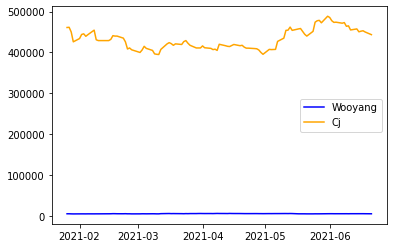

In [10]:
# visualization
plt.plot(my_data.index, my_data['Wooyang'], c='blue', label = 'Wooyang')
plt.plot(my_data.index, my_data['Cj'], c='orange', label = 'Cj')
plt.legend(loc='best')
plt.show()

In [11]:
# 1. Price, 2. Daily percent change, 3.Cumulative summation(누적합)
# Daily percent change 구하기 shift() 대각으로
wooyang_dpc = (my_data['Wooyang'] - my_data['Wooyang'].shift(1))/my_data['Wooyang'].shift(1)
wooyang_dpc[start_date] = 0
cj_dpc = (my_data['Cj'] - my_data['Cj'].shift(1))/my_data['Cj'].shift(1)
cj_dpc[start_date] = 0

df_dpc = pd.DataFrame()
df_dpc['Wooyang'] = wooyang_dpc
df_dpc['cj'] = cj_dpc



# Cumulative summation. cumsum() 누적합
df_cumsum = pd.DataFrame()
df_cumsum['WooyangCumsum'] = wooyang_dpc.cumsum()
df_cumsum['CjCumsum'] = cj_dpc.cumsum()
df_cumsum

temp_data = pd.concat([df_dpc, df_cumsum], axis = 1)
temp_data

,Wooyang,cj,WooyangCumsum,CjCumsum
Date,,,,
2021-01-26,0.000000,0.000000,0.000000,0.000000
2021-01-27,-0.001727,0.001085,-0.001727,0.001085
2021-01-28,-0.036332,-0.024919,-0.038059,-0.023834
2021-01-29,-0.023339,-0.053333,-0.061399,-0.077167
2021-02-01,0.020221,0.018779,-0.041178,-0.058388
...,...,...,...,...
2021-06-15,0.005042,-0.015301,0.056386,-0.007294
2021-06-16,0.000000,0.003330,0.056386,-0.003964
2021-06-17,-0.001672,0.002212,0.054714,-0.001752


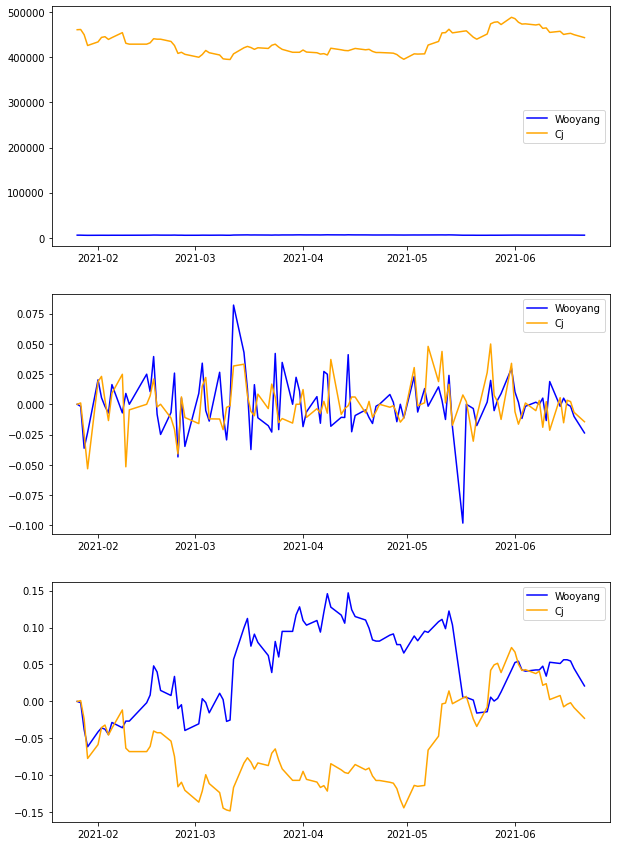

In [12]:
# visualization

plt.figure(figsize = (10,15))
plt.subplot(311)
plt.plot(my_data.index, my_data['Wooyang'], c='blue', label = 'Wooyang')
plt.plot(my_data.index, my_data['Cj'], c='orange', label = 'Cj')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(df_dpc.index, df_dpc['Wooyang'], c='blue', label = 'Wooyang')
plt.plot(df_dpc.index, df_dpc['cj'], c='orange', label = 'Cj')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(df_dpc.index, df_dpc['Wooyang'].cumsum(), c='blue', label = 'Wooyang')
plt.plot(df_dpc.index, df_dpc['cj'].cumsum(), c='orange', label = 'Cj')
plt.legend(loc='best')
plt.show()

[*********************100%***********************]  1 of 1 completed


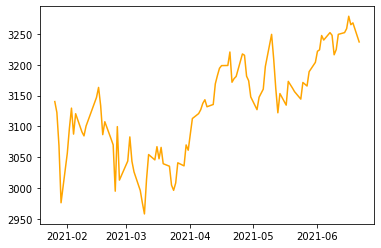

Date
2021-03-10   -0.064848
2021-03-11   -0.064848
2021-03-12   -0.064848
2021-03-15   -0.064848
2021-03-16   -0.064848
                ...   
2021-06-15   -0.064848
2021-06-16   -0.064848
2021-06-17   -0.064848
2021-06-18   -0.064848
2021-06-21   -0.064848
Name: Adj Close, Length: 72, dtype: float64


In [16]:
# 시작일, 종료일
start_date = datetime(2021, 1, 26)
end_date = datetime(2021, 6, 21)

# google -> 검색창 -> yahoo finance kospi
# KOSPI 지수 받아오기 '^KS11'

kospi_index = pdr.get_data_yahoo('^KS11', start_date, end_date)

window = 252
plt. plot(kospi_index.index, kospi_index['Adj Close'], c = 'orange')
plt.show()

# peak, drawdown, max_drawdown: rolling()
# window 기준으로 가장 높은 값을 찾는다.

peak = kospi_index['Adj Close'].rolling(window, min_periods=1).max()

# drawdown은 peak 로 부터 얼만큼 떨어졌는지(낙폭)

drawdown = kospi_index['Adj Close'] / peak - 1


# max_drawdown이 최소였던 지점(음수이기 때문에 min을 찾아야 drawdown이 max인 지점을 찾을 수 있음)
max_drawdown = drawdown.rolling(window, min_periods=1).min()
print(max_drawdown[max_drawdown == max_drawdown.min()])

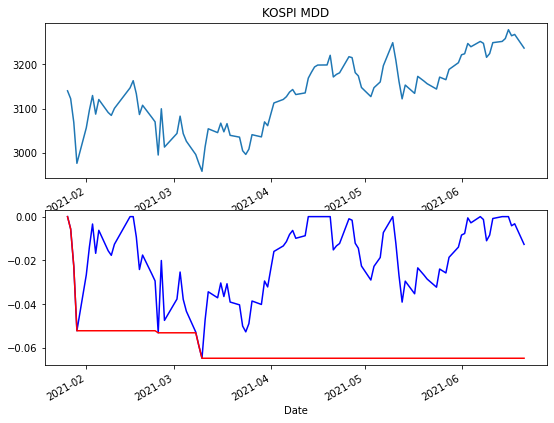

In [17]:
# visualization figsize=9,7

plt.figure(figsize=(9, 7))
plt.subplot(211)
kospi_index['Close'].plot(label='KOSPI', title='KOSPI MDD')
plt.subplot(212)
drawdown.plot(c='b', label='Drawdown')
max_drawdown.plot(c='red', label='Max Drawdown')
plt.show()


my_stocks = dict({'Wooyang': 'Wy', 'Cj': 'Cj', 'Pulmuwon': 'Pmw'})


df_stocks = pd.concat([Wy_close, Cj_close, Pmw_close], axis = 1, sort= False)
columns = ['Wooyang','Cj','Pulmuwon']
df_stocks.columns = columns

df_stocks.fillna(method='ffill', inplace=True)
df_stocks.fillna(method='bfill', inplace=True)

daily_ret = df_stocks.pct_change()
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252


port_weights = []
port_ret = []
port_risk = []
sharpe_ratio = []

my_res = pd.DataFrame()
my_res_left = pd.DataFrame()

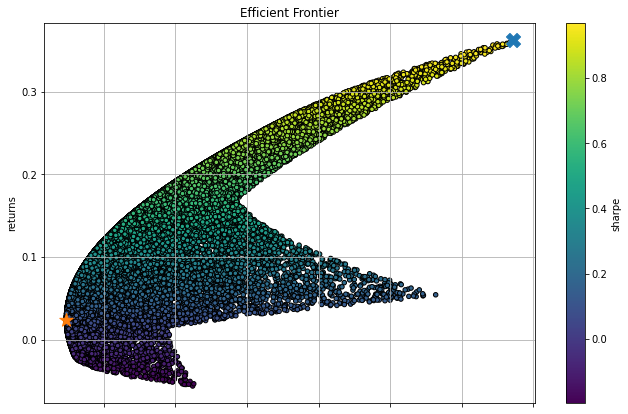

In [18]:
# 몬테카를로 시뮬레이션을 통한 다양한 포트폴리오의 생성 (포트폴리오 리스크 : sqrt ( (종목별비증)T((종목별 위험)(종목별비중) )
for _ in range(50000):
    # 1. 종목별 가중치 생성
    weights = np.random.random(len(my_stocks))
    weights /= np.sum(weights)
    # 2. 가중치에 따른 수익률 dot은 행렬 곱
    returns = np.dot(weights, annual_ret)
    # 3. 가중치에 따른 위험률
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))

    port_weights.append(weights)
    port_ret.append(returns)
    port_risk.append(risk)
    sharpe_ratio.append(returns / risk)

my_res_left['returns'] = port_ret
my_res_left['risk'] = port_risk
my_res_left['sharpe'] = sharpe_ratio

# res_portfolio_right dataframe 'my_stocks_weight' 생성
my_stock_weight = pd.DataFrame()
# 1. 종목별 가중치 전치 with np
transpose_weight = np.array(port_weights).T
# 2. 종목별 가중치 Dataframe 생성
for i, v in enumerate(my_stocks.keys()):
    my_stock_weight[v] = transpose_weight[i]

# 최종 데이터 프레임 생성 with concat
my_res = pd.concat([my_res_left, my_stock_weight], axis=1)
# sharpe_ratio : 1.max_sharpe, 2.min_risk
max_sharpe = my_res.loc[my_res['sharpe'] == my_res['sharpe'].max()]
min_risk = my_res.loc[my_res['risk'] == my_res['risk'].min()]

# chart visualization scatter, cmap=viridis, figsize = 11,7
my_res.plot.scatter(x='risk', y='returns', c='sharpe', cmap='viridis', edgecolors='black', figsize=(11, 7), grid=True)
plt.scatter(x=max_sharpe['risk'], y=max_sharpe['returns'], marker='X', s=200)
plt.scatter(x=min_risk['risk'], y=min_risk['returns'], marker='*', s=200)
plt.title('Efficient Frontier')
plt.show()

[*********************100%***********************]  1 of 1 completed


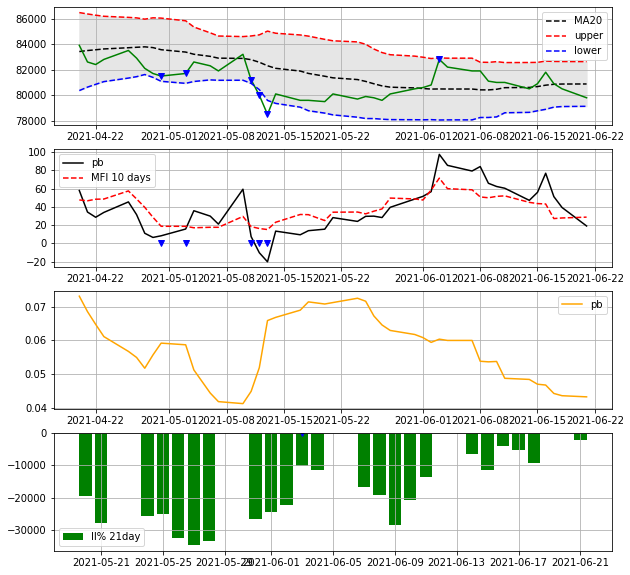

In [28]:
# 볼린저밴드

# 시작일, 종료일 ( 2019, 11, 3 ~ 2020, 12, 1 )
start_date = datetime(2021, 1, 26)
end_date = datetime(2021, 6, 21)


# get_data_yahoo '097950.KS'
yf.pdr_override()
Cj = pd.DataFrame()
Cj = pdr.get_data_yahoo('097950.KS', start_date, end_date)

# 볼린저밴드 MA20, stddev, upper, lower
df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['stddev'] = df['Close'].rolling(window=20, min_periods=1).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)

# 추세추종[trend following]
# 1.tp[typical price] = (고가 + 저가 + 종가)/3
df['tp'] = (df.High + df.Low + df.Close) / 3
# i 번째 tp < i+1 번째 tp 인경우 p(positive)mf -> 긍정적인 현금흐름
# i 번째 tp >= i+1 번째 tp 인경우 n(negative)mf -> 부정적인 현금흐름
df['pmf'] = 0
df['nmf'] = 0
for i in range(len(df.Close) - 1):
    if df.tp.values[i] < df.tp.values[i + 1]:
        # 중심가*거래량
        df.pmf.values[i + 1] = df.tp.values[i + 1] * df.Volume.values[i + 1]
        df.nmf.values[i + 1] = 0
    else:
        # df.tp.values[i] >= df.tp.values[i + 1]
        df.nmf.values[i + 1] = df.tp.values[i + 1] * df.Volume.values[i + 1]
        df.pmf.values[i + 1] = 0
# MFR(money flow ratio) : 10일 동안의 pmf의 합 / 10일 동안의 nmf의 합
df['mfr'] = df.pmf.rolling(window=10).sum() / df.nmf.rolling(window=10).sum()
# MFI10 : 10일 동안의 현금 흐름 100 - (100 / ( 1 + mfr ))
df['mfi10'] = 100 - (100 / (1 + df.mfr))
# 20일(window size)이전 데이터 정제
df = df[19:]


# 일중강도[intraday intensity]: 종가의 위치를 토대로 주식 종목의 자금흐름
# II = ( 2 * 종가 - 고가 - 저가 / 고가 - 저가 ) * 거래량
df['ii'] = (2 * df['Close'] - df['High'] - df['Low'] / df['High'] - df['Low']) * df['Volume']


# II%[intraday intensity %]: 거래량으로 II를 표준화 (21일) = 일중강도의 21일합 / 거래량의 21일 합 * 100
df['iip21'] = df.ii.rolling(window=21).sum() / df.Volume.rolling(window=21).sum() * 100


plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df.index, df.MA20, 'k--', label='MA20')
plt.plot(df.index, df.Close, c='green')
plt.plot(df.index, df.upper, 'r--', label='upper')
plt.plot(df.index, df.lower, 'b--', label='lower')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')

for i in range(len(df.Close)):
    if df.pb.values[i] > 0.8 and df.mfi10.values[i] > 80:
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')
    elif df.pb.values[i] < 0.2 and df.mfi10.values[i] < 20:
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')
for i in range(len(df.Close)):
    if df.pb.values[i] < 0.05 and df.iip21.values[i] > 0:
        plt.plot(df.index.values[i], df.Close.values[i], 'r^')
    elif df.pb.values[i] > 0.95 and df.iip21.values[i] < 0:
        plt.plot(df.index.values[i], df.Close.values[i], 'bv')

# plot [ %b, mfi 10 ] figsize = 10, 5
plt.legend(loc='best')
plt.grid(True)
plt.subplot(412)
plt.plot(df.index, df.pb * 100, c='black', label='pb')
plt.plot(df.index, df.mfi10, 'r--', label='MFI 10 days')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])

# plot [ 추세추종 매매 시기 (매수) pb > 0.8, mfi > 80 (매도) pb < 0.2, mfi < 20
for i in range(len(df.Close)):
    if df.pb.values[i] > 0.8 and df.mfi10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] < 0.2 and df.mfi10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')


# plot [ 추세추종 매매 시기 (매수) pb <0.05  iip21>0, (매도) pb >0.95  iip21<0
plt.grid(True)
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.index, df.bandwidth, c='orange', label='pb')
plt.grid(True)
plt.legend(loc='best')
plt.subplot(414)
plt.bar(df.index, df['iip21'], color='g', label='II% 21day')
for i in range(len(df.Close)):
    if df.pb.values[i] < 0.05 and df.iip21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.pb.values[i] > 0.95 and df.iip21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()